In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb

from plotly.subplots import make_subplots
from multiprocessing import Pool
from functools import partial
from utils.common import read_bm_data, plot_confusion_matrix
from scipy.stats import ttest_rel, pearsonr, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sktime.transformations.series.detrend import STLTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import os
import ta
import datetime
import tqdm
import pickle

In [2]:
if os.path.exists('./large_files/cl-1m.pkl'):
    df_wti_1m = pickle.load(open('./large_files/cl-1m.pkl', 'rb'))
else:
    df_wti_1m = read_bm_data('./large_files/cl-1m.csv')
    pickle.dump(df_wti_1m, open('./large_files/cl-1m.pkl', 'wb'))

df_wti_1m = df_wti_1m[(df_wti_1m['datetime'].dt.hour >= 8) & (df_wti_1m['datetime'].dt.hour < 16)]

df_wti = read_bm_data('./data/backtestmarket/cl-15m.csv')
# take only wednesday data for 10 years

df = df_wti.copy()
df = df[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 16)]
df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
df.head()

,date,time,open,high,low,close,volume,datetime,day
65914,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday
65915,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday
65916,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday
65917,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday
65918,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday


In [3]:
# define some common time
NINE = pd.to_datetime('09:00:00')
NINE_THIRTY = pd.to_datetime('09:30:00')
TEN = pd.to_datetime('10:00:00')
TEN_THIRTY = pd.to_datetime('10:30:00')
ELEVEN = pd.to_datetime('11:00:00')
TWELVE = pd.to_datetime('12:00:00')

# Idea
Hypothesis: Say price is moving upwards and let's take 15 minute as our window size. In every 15 minute window, the mean price should be far from the high (we can compute this using 1m data) while price is moving up. When the close price is almost at its peak, the mean price within the 15m window should start moving away from the high of the window. We should then expect a direction change (price going down).   

So, we can leverage the distance of the mean to the high within a window to predict when the price is going to turn direction.

In [4]:
def plot_candlestick(df, title='', column='high_dst_15m'):
    
    # fig = go.Figure()
    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    fig.add_trace(
        go.Candlestick(
            x=df['datetime'],
            open=df['open'],
            low=df['low'],
            high=df['high'],
            close=df['close'],
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df['datetime'],
            y=df[column],
            mode='lines'
        ),
        secondary_y=True
    )
    
    fig.update_layout(
        title=f'{title}',
        xaxis_title='Datetime',
        yaxis_title='Price ($)',
        xaxis_rangeslider_visible=False,
        width=2000,
        height=500,
        # template='plotly_dark',
        template='plotly',
        # yaxis2=dict(range=[0.3, 0.7])
    )
    
    fig.show()

Get distance between mean and high in a 15m window, formula  
$$distance = (high - mean) / (high - low)$$

In [5]:
# test out idea

df_test = []
counter = 0
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue

    df_day_1m = df_wti_1m[
        (df_wti_1m['datetime'] >= df_day['datetime'].iloc[0]) &
        (df_wti_1m['datetime'] < (df_day['datetime'].iloc[-1] + pd.Timedelta(minutes=15)))
    ]

    distances = []
    for time_range, df_tmp in df_day_1m.groupby(pd.Grouper(key='datetime', freq='15min')):
        mean = df_tmp['close'].mean()
        high = df_tmp['high'].max()
        low = df_tmp['low'].min()
        # distance to high, approaching 0 means getting closer
        dist = (high - mean) / (high - low)
        distances.append({'datetime': pd.to_datetime(time_range), 'high_dst_15m': dist})
    distances = pd.DataFrame(distances)

    df_day = pd.merge(left=df_day, right=distances, how='left', on='datetime')
    df_test.append(df_day)

df_test = pd.concat(df_test).sort_values('datetime')
df_test.head()

 49%|████▉     | 1786/3634 [00:03<00:03, 536.77it/s]/tmp/ipykernel_28854/4208973785.py:20: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
100%|██████████| 3634/3634 [00:06<00:00, 525.73it/s]


,date,time,open,high,low,close,volume,datetime,day,high_dst_15m
0,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday,0.435897
1,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday,0.406667
2,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday,0.423810
3,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday,0.502564
4,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,0.632000


Test using 5m window size as well

In [6]:
# test out idea

df_uturn = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue

    df_day_1m = df_wti_1m[
        (df_wti_1m['datetime'] >= df_day['datetime'].iloc[0]) &
        (df_wti_1m['datetime'] < (df_day['datetime'].iloc[-1] + pd.Timedelta(minutes=5)))
    ]

    distances = []
    for time_range, df_tmp in df_day_1m.groupby(pd.Grouper(key='datetime', freq='5min')):
        mean = df_tmp['close'].mean()
        high = df_tmp['high'].max()
        low = df_tmp['low'].min()
        # distance to high, approaching 0 means getting closer
        dist = (high - mean) / (high - low)
        distances.append({'datetime': pd.to_datetime(time_range), 'high_dst_5m': dist})
    distances = pd.DataFrame(distances)

    df_day = pd.merge(left=df_day, right=distances, how='left', on='datetime')
    df_uturn.append(df_day)

df_uturn = pd.concat(df_uturn).sort_values('datetime')
df_test['high_dst_5m'] = df_uturn['high_dst_5m']
df_test.head()

 15%|█▌        | 547/3634 [00:01<00:10, 292.58it/s]/tmp/ipykernel_28854/1105857807.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
/tmp/ipykernel_28854/1105857807.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
 25%|██▍       | 897/3634 [00:03<00:08, 305.37it/s]/tmp/ipykernel_28854/1105857807.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
 26%|██▌       | 932/3634 [00:03<00:08, 308.98it/s]/tmp/ipykernel_28854/1105857807.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  dist = (high - mean) / (high - low)
 35%|███▌      | 1282/3634 [00:04<00:07, 309.00it/s]/tmp/ipykernel_28854/1105857807.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dist = (high - mean) / (high - low)
 45%|████▌     | 1646/3634 [00:05<00:06, 319.39it/s]/tmp/ipykernel_28854/1105857807.py:19: RuntimeWarning: invalid

,date,time,open,high,low,close,volume,datetime,day,high_dst_15m,high_dst_5m
0,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday,0.435897,0.440000
1,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday,0.406667,0.240000
2,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday,0.423810,0.373333
3,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday,0.502564,0.640000
4,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,0.632000,0.720000


Red line indicates the distance between mean and high within a candlestick (right y-axis)  
Ideally  
- A drop in the red line (distance of mean and high getting closer) should be followed by an upward trend in the candle stick (for example the next candle stick should close higher than open);
- Vice versa, if we see peak in the red line (distance of mean and high getting farther, could be end of price going upward) we should expect a downward trend in the candle stick.

In [7]:
days = df_test['datetime'].dt.date.unique()
np.random.shuffle(days)

for day in days[:3]:
    df_day = df_test[df_test['datetime'].dt.date == day]
    plot_candlestick(df_day, day)

Red line is very jagged and is challenging to interpret.  
Get rolling difference of the distance between mean and high.  

- Positive value (distance getting farther away): price direction should switch to moving down
- Negative value (distance getting closer): price should start moving up

In [8]:
df_test['dst_diff_15m'] = df_test['high_dst_15m'].diff(1)
for day in days[:3]:
    df_day = df_test[df_test['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'dst_diff_15m')

Try using simple moving average of the distance to see it helps with visualization

In [9]:
window_size = 4
sma_values = df_test.groupby(df_test['datetime'].dt.date)['high_dst_15m'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
df_test['high_dst_15m_sma'] = sma_values

for day in days[:3]:
    df_day = df_test[df_test['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'high_dst_15m_sma')

Same experiments but the window to get distance between mean and high is 5m.

In [10]:
for day in days[:3]:
    df_day = df_test[df_test['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'high_dst_5m')

Simple moving average of distance

In [11]:
window_size = 4
sma_values = df_test.groupby(df_test['datetime'].dt.date)['high_dst_5m'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
df_test['high_dst_5m_sma'] = sma_values

for day in days[:3]:
    df_day = df_test[df_test['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'high_dst_5m_sma')

Rolling difference of distance (5m)

In [12]:
df_test['dst_diff_5m'] = df_test['high_dst_5m'].diff(1)
for day in days[:3]:
    df_day = df_test[df_test['datetime'].dt.date == day]
    plot_candlestick(df_day, day, 'dst_diff_5m')

Summary:
1. There are subtle hints that this distance feature could be useful.
1. But it is too slow. While there are a few instances where the distances peak or drop BEFORE a price direction change, they usually happen during the price direction change.
1. Rolling difference seems to be useful when it is >0.2 or <-0.2

# Defining up, down and neutral

In [13]:
df_result = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    # 1030
    df_1030 = df_day[(df_day['datetime'].dt.time >= TEN_THIRTY.time())]

    # the grouper function will generate every day sequentially even if
    # it is not in dataframe
    if (df_1030.shape[0] == 0) or (day.strftime('%A') != 'Wednesday'):
        continue
    price = df_1030['close'].values[0]

    # past hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= NINE_THIRTY.time()) &
        (df_day['datetime'].dt.time < TEN_THIRTY.time())
    ]
    mean_hr_1 = df_past['close'].mean()
    std_hr_1 = df_past['close'].std()
    z_hr_1 = (price - mean_hr_1) / std_hr_1
    pct_hr_1 = np.round(((price - mean_hr_1) / mean_hr_1) * 100, 2)

    # past half hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= TEN.time()) &
        (df_day['datetime'].dt.time < TEN_THIRTY.time())
    ]
    mean_min_30 = df_past['close'].mean()
    std_min_30 = df_past['close'].std()
    z_min_30 = (price - mean_min_30) / std_min_30
    pct_min_30 = np.round(((price - mean_min_30) / mean_min_30) * 100, 2)

    result = {
        'date': df_1030['datetime'].iloc[0],
        '1030_close': price,
        'z_hr_1': z_hr_1,
        'pct_hr_1': pct_hr_1,
        'std_hr_1': std_hr_1,
        'mean_hr_1': mean_hr_1,
        'z_min_30': z_min_30,
        'pct_min_30': pct_min_30,
        'std_min_30': std_min_30,
        'mean_min_30': mean_min_30
    }
    df_result.append(result)

df_result = pd.DataFrame(df_result)
df_result.head(5)

  0%|          | 0/3634 [00:00<?, ?it/s]

  5%|▌         | 186/3634 [00:00<00:01, 1858.44it/s]/tmp/ipykernel_28854/240394616.py:29: RuntimeWarning:

divide by zero encountered in scalar divide

100%|██████████| 3634/3634 [00:01<00:00, 2072.54it/s]


,date,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
0,2010-01-06 10:30:00-05:00,81.24,-2.566472,-0.84,0.267877,81.9275,-2.687006,-1.04,0.318198,82.095
1,2010-01-13 10:30:00-05:00,78.87,-2.429735,-0.88,0.288097,79.5700,-21.448906,-0.57,0.021213,79.325
2,2010-01-20 10:30:00-05:00,77.49,-1.051497,-0.37,0.273420,77.7775,-0.344488,-0.12,0.275772,77.585
3,2010-01-27 10:30:00-05:00,74.15,-2.891874,-0.51,0.131403,74.5300,-1.936858,-0.42,0.162635,74.465
4,2010-02-03 10:30:00-05:00,77.11,-1.885800,-0.32,0.131244,77.3575,-4.384062,-0.20,0.035355,77.265


In [14]:
df_result.describe()

,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,72.472278,-0.008611,0.023378,0.140167,72.463789,NaN,0.014691,0.084634,72.466660
std,21.881305,4.684590,0.549260,0.109783,21.898777,NaN,0.504290,0.083358,21.889992
min,28.030000,-33.935934,-3.180000,0.010000,27.817500,-inf,-2.870000,0.000000,27.990000
25%,52.460000,-1.287411,-0.220000,0.067453,52.378125,-2.098510,-0.200000,0.028284,52.355000
50%,71.705000,0.246098,0.035000,0.117969,71.347500,0.150080,0.010000,0.060104,71.462500
75%,93.482500,1.488642,0.280000,0.176657,93.501250,2.469674,0.230000,0.106066,93.502500
max,112.300000,37.328178,2.680000,1.084293,112.322500,inf,3.280000,0.643467,112.430000


<Axes: >

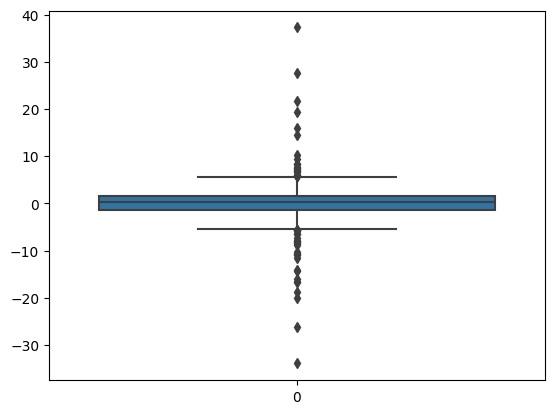

In [15]:
sns.boxplot(data=df_result['z_hr_1'])

In [16]:
df_pos = df_result[df_result['z_hr_1'] >= 0]
df_neg = df_result[df_result['z_hr_1'] < 0]

display(df_pos.describe())
display(df_neg.describe())

,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,71.158246,2.316690,0.357579,0.137647,70.928035,NaN,0.286632,0.084902,70.974386
std,21.632040,3.674623,0.404728,0.109789,21.618157,NaN,0.397338,0.089273,21.620346
min,28.030000,0.000000,0.000000,0.010000,27.817500,-inf,-0.970000,0.000000,27.990000
25%,52.250000,0.695019,0.100000,0.067823,52.017500,0.518545,0.050000,0.028284,52.185000
50%,67.510000,1.370497,0.230000,0.114710,67.480000,2.121320,0.200000,0.056569,67.505000
75%,93.400000,2.513315,0.460000,0.179141,93.245000,4.949747,0.430000,0.106066,93.270000
max,108.620000,37.328178,2.680000,1.084293,108.545000,inf,3.280000,0.643467,108.605000


,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,74.079571,-2.852863,-0.385408,0.143249,74.342285,NaN,-0.317940,0.084307,74.291974
std,22.122772,4.196179,0.408339,0.109933,22.138903,NaN,0.414105,0.075685,22.125041
min,28.310000,-33.935934,-3.180000,0.014142,28.560000,-inf,-2.870000,0.000000,28.525000
25%,52.950000,-2.963892,-0.510000,0.065574,52.995000,-6.363961,-0.420000,0.028284,53.125000
50%,76.170000,-1.506891,-0.270000,0.123288,77.035000,-2.298097,-0.210000,0.063640,76.700000
75%,93.810000,-0.786759,-0.130000,0.172892,93.972500,-0.707107,-0.080000,0.113137,94.005000
max,112.300000,-0.019012,-0.010000,0.664806,112.322500,inf,0.430000,0.388909,112.430000


In [17]:
# 20% quantile
pos_20_quant = df_pos['z_hr_1'].quantile(0.2)
df_pos[df_pos['z_hr_1'] <= pos_20_quant].describe()

,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,72.854211,0.261094,0.049649,0.139105,72.821184,-inf,-0.023509,0.075053,72.867456
std,21.401158,0.143321,0.042425,0.107148,21.400953,NaN,0.192433,0.067781,21.393793
min,42.740000,0.000000,0.000000,0.017078,42.720000,-inf,-0.970000,0.000000,42.610000
25%,51.120000,0.147979,0.020000,0.078740,51.060000,-1.066653,-0.090000,0.035355,51.160000
50%,73.790000,0.292603,0.040000,0.119024,73.780000,-0.353553,-0.030000,0.056569,73.875000
75%,91.280000,0.372189,0.070000,0.167829,91.272500,0.707107,0.070000,0.091924,91.340000
max,106.100000,0.495434,0.170000,0.610539,106.062500,9.899495,0.420000,0.417193,106.185000


In [18]:
df_pos[df_pos['z_hr_1'] <= 0.5].sample(5)

,date,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
449,2018-08-29 10:30:00-04:00,69.11,0.385392,0.04,0.071356,69.0825,-1.414214,-0.03,0.014142,69.13
301,2015-10-28 10:30:00-04:00,43.68,0.349053,0.10,0.121758,43.6375,-inf,-0.14,0.000000,43.74
10,2010-03-17 10:30:00-04:00,82.54,0.228748,0.02,0.065574,82.5250,-0.117851,-0.01,0.084853,82.55
213,2014-02-19 10:30:00-05:00,102.42,0.413405,0.05,0.133041,102.3650,-1.414214,-0.04,0.028284,102.46
507,2019-10-09 10:30:00-04:00,53.41,0.476031,0.17,0.194315,53.3175,-0.824958,-0.13,0.084853,53.48


<Axes: ylabel='Frequency'>

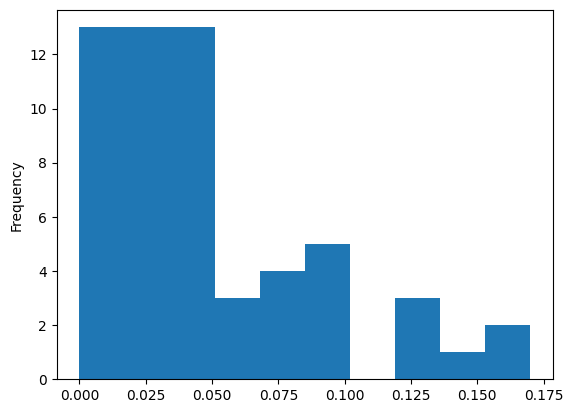

In [19]:
df_pos.loc[df_pos['z_hr_1'] <= 0.5, 'pct_hr_1'].plot.hist()

In [20]:
# 20% quantile
neg_20_quant = df_neg['z_hr_1'].quantile(0.8)
df_neg[df_neg['z_hr_1'] >= neg_20_quant].describe()

,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,72.669149,-0.301231,-0.076596,0.176098,72.726011,NaN,-0.023830,0.079136,72.688298
std,21.907452,0.191467,0.080549,0.134138,21.924043,NaN,0.167651,0.066995,21.918282
min,36.750000,-0.642377,-0.390000,0.023805,36.752500,-inf,-0.330000,0.000000,36.640000
25%,53.260000,-0.431885,-0.090000,0.089582,53.287500,-1.214773,-0.135000,0.028284,53.255000
50%,67.650000,-0.302580,-0.060000,0.147507,67.745000,-0.286665,-0.050000,0.070711,67.845000
75%,93.005000,-0.133189,-0.020000,0.193839,93.082500,1.269166,0.100000,0.113137,93.022500
max,112.300000,-0.019012,-0.010000,0.615054,112.322500,inf,0.430000,0.289914,112.430000


In [21]:
df_neg[df_neg['z_hr_1'] >= -0.5].sample(5)

,date,1030_close,z_hr_1,pct_hr_1,std_hr_1,mean_hr_1,z_min_30,pct_min_30,std_min_30,mean_min_30
327,2016-04-27 10:30:00-04:00,44.90,-0.220625,-0.04,0.079320,44.9175,-0.192847,-0.03,0.077782,44.915
395,2017-08-16 10:30:00-04:00,47.80,-0.024254,-0.01,0.103078,47.8025,-inf,-0.19,0.000000,47.890
294,2015-09-09 10:30:00-04:00,45.58,-0.367402,-0.07,0.088459,45.6125,-0.424264,-0.13,0.141421,45.640
310,2015-12-30 10:30:00-05:00,36.75,-0.019012,-0.01,0.131498,36.7525,3.889087,0.30,0.028284,36.640
50,2010-12-22 10:30:00-05:00,90.50,-0.434099,-0.06,0.115181,90.5500,-4.101219,-0.16,0.035355,90.645


<Axes: ylabel='Frequency'>

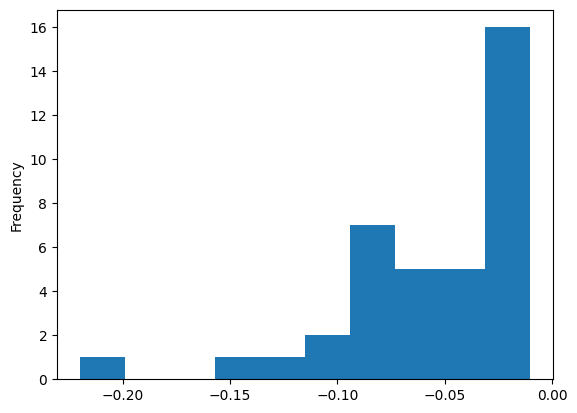

In [22]:
df_neg.loc[df_neg['z_hr_1'] >= -0.5, 'pct_hr_1'].plot.hist()

Summary

- Use 15 minutes data
- z-score relative to past hour mean
- 0 < z < 0.5, percentage change < 0.175 %
- -0.5 < z < 0, percentage change < 0.2 %
- -0.5 < z < 0.5 = neutral  

TODO: use percentage

# Features

### Z score relative to past time periods

Notes:
1. In the 15m data, sometimes there may be a few consecutive time stamps recording the same closing price and the std will be 0.
1. To prevent this, we can use the 1m data to compute mean / std for every 15m window

In [23]:
def z_past(sr, lag_hr, lag_minute, name):
    timestamp = sr['datetime']
    start = timestamp - pd.Timedelta(hours=lag_hr, minutes=lag_minute)
    df_past = df_wti_1m[
        (df_wti_1m['datetime'] >= start) & 
        (df_wti_1m['datetime'] < timestamp)
    ]

    if df_past.shape[0] == 0:
        mean = sr['close']
        std = 0
        z = 0
        pct = 0
    else:
        mean = df_past['close'].mean()
        std = df_past['close'].std()

        # prevent division by 0
        if std == 0:
            std = np.nan

        z = (sr['close'] - mean) / std
        pct = np.round(((sr['close'] - mean) / mean) * 100, 2)

    sr[f'z_{name}'] = z
    sr[f'pct_{name}'] = pct
    sr[f'mean_{name}'] = mean
    sr[f'std_{name}'] = std
    if z > 0.5:
        sr[f'direction_{name}'] = 'up'
    elif z < -0.5:
        sr[f'direction_{name}'] = 'down'
    else:
        sr[f'direction_{name}'] = 'neutral'

    return sr

In [24]:
df_data_sr = df.to_dict(orient='records')
partial_function = partial(z_past, lag_hr=1, lag_minute=0, name='1hr')
with Pool(10) as p:
    df_data = list(tqdm.tqdm(p.starmap(partial_function, [(element,) for element in df_data_sr])))
df_data = pd.DataFrame(df_data)

100%|██████████| 16545/16545 [00:00<00:00, 7000379.27it/s]


In [25]:
df_data_sr = df_data.to_dict(orient='records')
partial_function = partial(z_past, lag_hr=0, lag_minute=30, name='30m')
with Pool(10) as p:
    df_data = list(tqdm.tqdm(p.starmap(partial_function, [(element,) for element in df_data_sr])))
df_data = pd.DataFrame(df_data)

100%|██████████| 16545/16545 [00:00<00:00, 4974891.37it/s]


In [26]:
df_data_sr = df_data.to_dict(orient='records')
partial_function = partial(z_past, lag_hr=0, lag_minute=15, name='15m')
with Pool(10) as p:
    df_data = list(tqdm.tqdm(p.starmap(partial_function, [(element,) for element in df_data_sr])))
df_data = pd.DataFrame(df_data)

100%|██████████| 16545/16545 [00:00<00:00, 5198498.74it/s]


- z_1hr: std relative to mean price of past hour.
- z_30m: std relative to mean price of past 30m.
  
- direction_1hr: direction of price compared to mean of past hour
- direction_30m: direction of price compare to mean of last 30m

In [27]:
df_data.head()

,date,time,open,high,low,close,volume,datetime,day,z_1hr,...,z_30m,pct_30m,mean_30m,std_30m,direction_30m,z_15m,pct_15m,mean_15m,std_15m,direction_15m
0,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday,0.000000,...,0.000000,0.00,81.600000,0.000000,neutral,0.000000,0.00,81.600000,0.000000,neutral
1,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday,-0.964165,...,-0.964165,-0.04,81.573333,0.034572,down,-0.964165,-0.04,81.573333,0.034572,down
2,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday,5.789259,...,5.789259,0.21,81.576333,0.029998,up,6.696551,0.21,81.579333,0.025486,up
3,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday,3.022819,...,2.565209,0.24,81.640333,0.077836,up,2.212891,0.17,81.701333,0.062663,up
4,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,1.509841,...,1.007236,0.08,81.738000,0.061555,up,0.785194,0.03,81.774667,0.032264,up


<Axes: ylabel='direction_15m'>

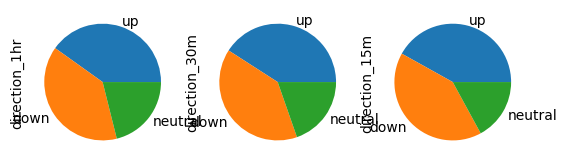

In [28]:
fig, ax = plt.subplots(1, 3)
df_data['direction_1hr'].value_counts().plot.pie(ax=ax[0])
df_data['direction_30m'].value_counts().plot.pie(ax=ax[1])
df_data['direction_15m'].value_counts().plot.pie(ax=ax[2])

<Axes: xlabel='z_1hr', ylabel='z_30m'>

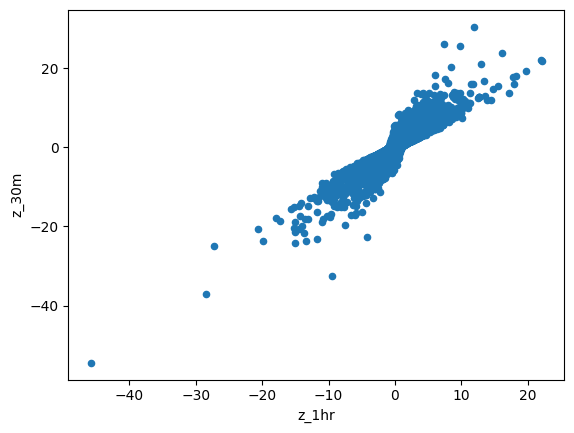

In [29]:
df_data.plot.scatter(x='z_1hr', y='z_30m')

<Axes: xlabel='z_30m', ylabel='z_15m'>

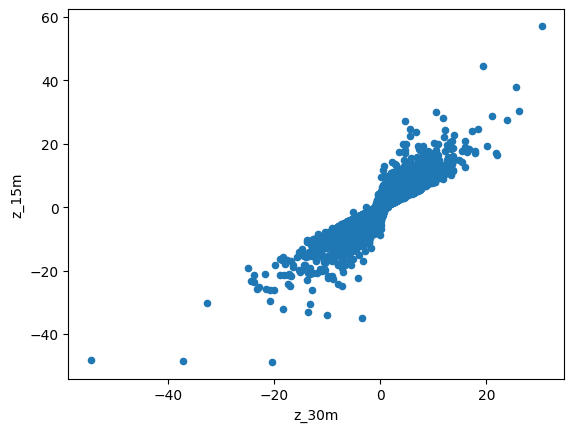

In [30]:
df_data.plot.scatter(x='z_30m', y='z_15m')

In [31]:
df_data['high_dst_15m_sma'] = df_test['high_dst_15m_sma'].values
df_data['high_dst_5m_sma'] = df_test['high_dst_5m_sma'].values

df_data['dst_diff_15m'] = df_test['dst_diff_15m'].values
df_data['dst_diff_5m'] = df_test['dst_diff_5m'].values

- When blue is positive (left y-axis) (say more than 0.2), price should switch direction to down and vice versa 
- Note that the price direction (up / down / neutral) is compared to the mean of the past hour

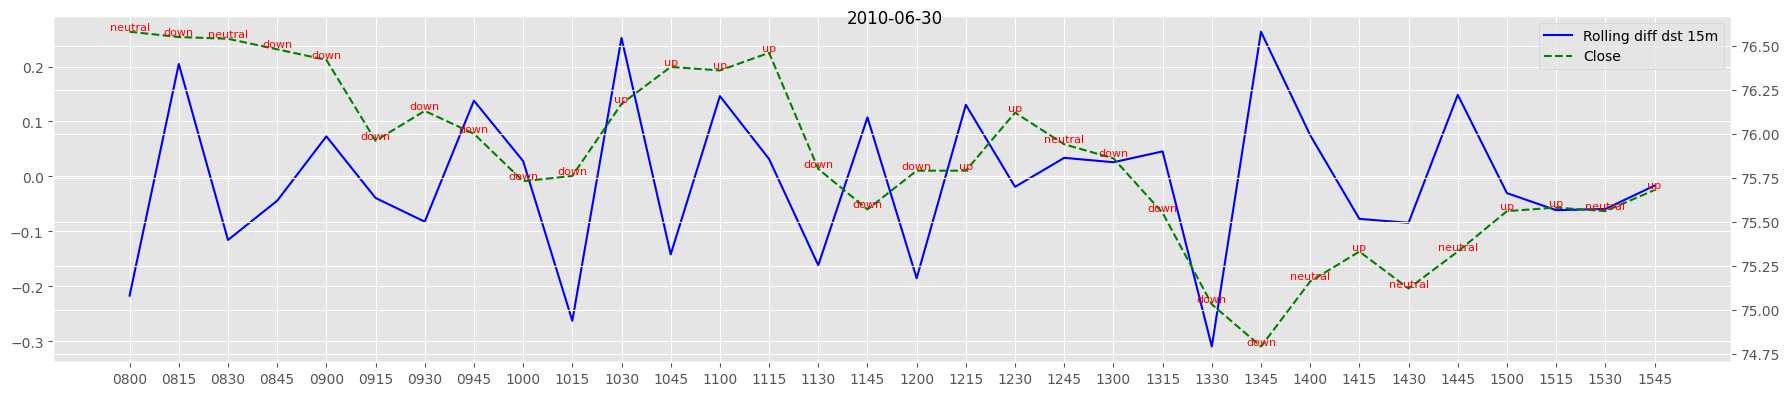

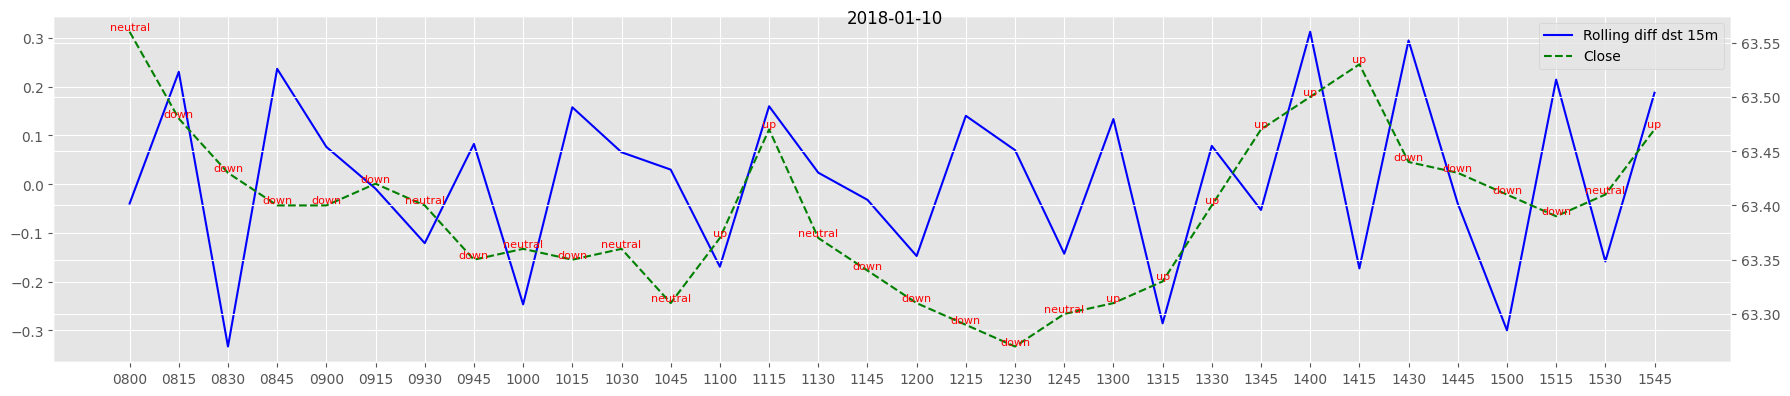

In [32]:
days = df_data['datetime'].dt.date.unique()
np.random.shuffle(days)

plt.style.use('ggplot')
for day in days[:2]:
    df_day = df_data[df_data['datetime'].dt.date == day]
    df_day = df_day.reset_index(drop=True)
    fig, ax1 = plt.subplots(figsize=(18, 4))
    line1 = ax1.plot(df_day['time'], df_day['dst_diff_15m'], color='blue', label='Rolling diff dst 15m')
        
    ax2 = ax1.twinx() 
    line2 = ax2.plot(df_day['time'], df_day['close'], color='green', linestyle='--', label='Close')

    for i, direction in enumerate(df_day['direction_30m']):
        ax2.text(df_day.loc[i, 'time'], df_day.loc[i, 'close'], direction,
                ha='center', va='bottom', fontsize=8, color='red')
    
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(day)

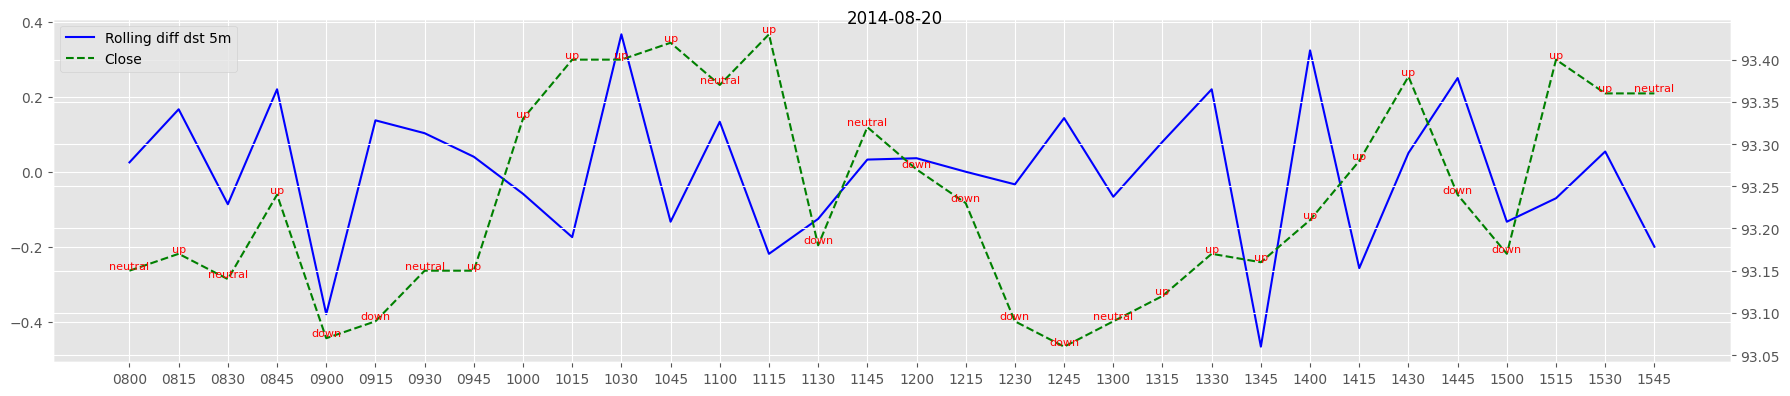

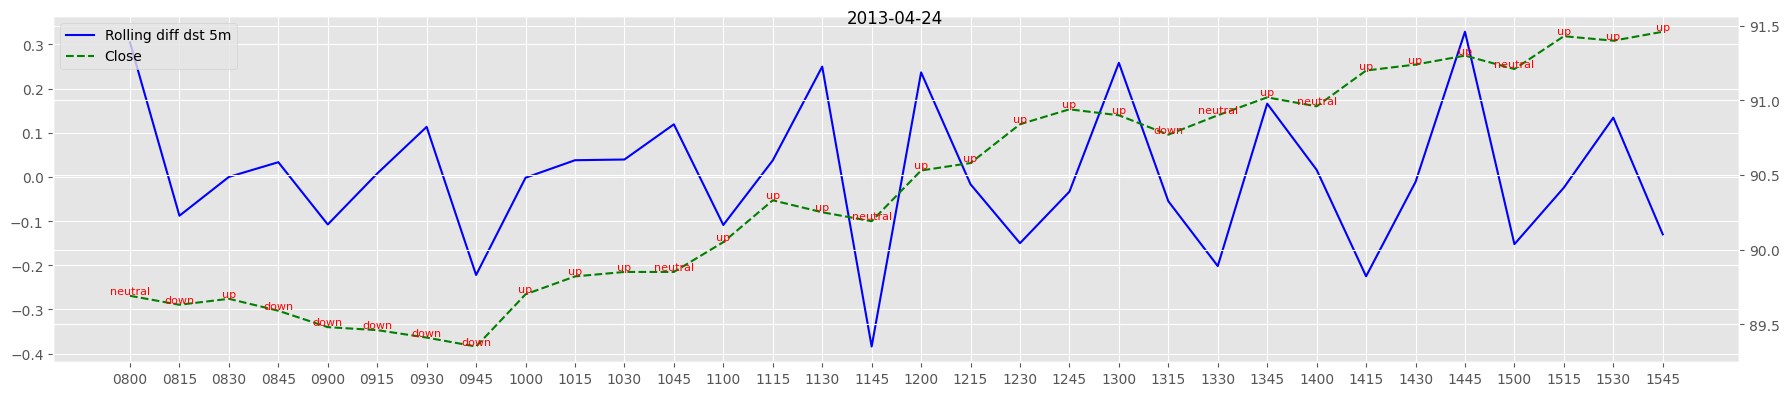

In [33]:
days = df_data['datetime'].dt.date.unique()
np.random.shuffle(days)

plt.style.use('ggplot')
for day in days[:2]:
    df_day = df_data[df_data['datetime'].dt.date == day]
    df_day = df_day.reset_index(drop=True)
    fig, ax1 = plt.subplots(figsize=(18, 4))
    line1 = ax1.plot(df_day['time'], df_day['dst_diff_5m'], color='blue', label='Rolling diff dst 5m')
        
    ax2 = ax1.twinx() 
    line2 = ax2.plot(df_day['time'], df_day['close'], color='green', linestyle='--', label='Close')

    for i, direction in enumerate(df_day['direction_30m']):
        ax2.text(df_day.loc[i, 'time'], df_day.loc[i, 'close'], direction,
                ha='center', va='bottom', fontsize=8, color='red')
    
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(day)

In [34]:
days = df_data['datetime'].dt.date.unique()
df_result = []
for day in days:
    df_day = df_data[df_data['datetime'].dt.date == day]
    indices = df_day[df_day['dst_diff_15m'] >= 0.2].index
    df_day = df_day.copy()

    # Create a new column to track consecutive down timesteps
    df_day['consecutive_down'] = 0

    # Count consecutive down timesteps after dst_diff_15m >= 0.2
    for idx in indices:
        count_down = 0
        next_idx = idx + 1
        
        while next_idx <= indices[-1] and df_day.at[next_idx, 'direction_1hr'] == 'down':
            count_down += 1
            next_idx += 1
        
        df_day.at[idx, 'consecutive_down'] = count_down

    df_result.append(df_day)

df_result = pd.concat(df_result)
df_result.head()

,date,time,open,high,low,close,volume,datetime,day,z_1hr,...,z_15m,pct_15m,mean_15m,std_15m,direction_15m,high_dst_15m_sma,high_dst_5m_sma,dst_diff_15m,dst_diff_5m,consecutive_down
0,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday,0.000000,...,0.000000,0.00,81.600000,0.000000,neutral,0.435897,0.440000,NaN,NaN,0
1,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday,-0.964165,...,-0.964165,-0.04,81.573333,0.034572,down,0.421282,0.340000,-0.029231,-0.200000,0
2,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday,5.789259,...,6.696551,0.21,81.579333,0.025486,up,0.422125,0.351111,0.017143,0.133333,0
3,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday,3.022819,...,2.212891,0.17,81.701333,0.062663,up,0.442234,0.423333,0.078755,0.266667,0
4,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,1.509841,...,0.785194,0.03,81.774667,0.032264,up,0.491260,0.493333,0.129436,0.080000,0


In [35]:
test = df_result[df_result['dst_diff_15m'] >= 0.2]
test[['consecutive_down', 'dst_diff_15m', 'dst_diff_5m']].describe()

,consecutive_down,dst_diff_15m,dst_diff_5m
count,1117.000000,1117.000000,1115.000000
mean,0.733214,0.258468,0.137616
std,1.841501,0.050651,0.159480
min,0.000000,0.200168,-0.371505
25%,0.000000,0.220355,0.033473
50%,0.000000,0.245543,0.138126
75%,0.000000,0.282716,0.250000
max,15.000000,0.544796,0.666667


# Trend  
SMA and EMA

In [36]:
df_result = []
for day, df_day in tqdm.tqdm(df_data.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_day['ema_1hr'] = ta.trend.ema_indicator(close=df_day['close'], window=4)
    df_day['ema_2hr'] = ta.trend.ema_indicator(close=df_day['close'], window=8)
    df_day['sma_1hr'] = ta.trend.sma_indicator(close=df_day['close'], window=4)
    df_day['sma_2hr'] = ta.trend.sma_indicator(close=df_day['close'], window=8)

    df_result.append(df_day)

df_result = pd.concat(df_result)
df_result.head()

  0%|          | 1/3634 [00:00<07:26,  8.13it/s]

100%|██████████| 3634/3634 [00:00<00:00, 5391.32it/s]


,date,time,open,high,low,close,volume,datetime,day,z_1hr,...,std_15m,direction_15m,high_dst_15m_sma,high_dst_5m_sma,dst_diff_15m,dst_diff_5m,ema_1hr,ema_2hr,sma_1hr,sma_2hr
0,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday,0.000000,...,0.000000,neutral,0.435897,0.440000,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday,-0.964165,...,0.034572,down,0.421282,0.340000,-0.029231,-0.200000,NaN,NaN,NaN,NaN
2,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday,5.789259,...,0.025486,up,0.422125,0.351111,0.017143,0.133333,NaN,NaN,NaN,NaN
3,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday,3.022819,...,0.062663,up,0.442234,0.423333,0.078755,0.266667,81.723360,NaN,81.6825,NaN
4,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,1.509841,...,0.032264,up,0.491260,0.493333,0.129436,0.080000,81.754016,NaN,81.7325,NaN


In [37]:
df_data = df_result.copy()

# Momentum  
Rate of Change 

In [38]:
df_result = []
for day, df_day in tqdm.tqdm(df_data.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue

    df_day = df_day.copy()
    df_day['roc_1hr'] = ta.momentum.ROCIndicator(df_day['close'], window=4).roc()
    df_day['roc_2hr'] = ta.momentum.ROCIndicator(df_day['close'], window=8).roc()

    df_result.append(df_day)

df_result = pd.concat(df_result)
df_result.head()

100%|██████████| 3634/3634 [00:00<00:00, 5831.72it/s]


,date,time,open,high,low,close,volume,datetime,day,z_1hr,...,high_dst_15m_sma,high_dst_5m_sma,dst_diff_15m,dst_diff_5m,ema_1hr,ema_2hr,sma_1hr,sma_2hr,roc_1hr,roc_2hr
0,2010-01-06,0800,81.54,81.63,81.50,81.60,1176,2010-01-06 08:00:00-05:00,Wednesday,0.000000,...,0.435897,0.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-06,0815,81.59,81.62,81.52,81.54,2042,2010-01-06 08:15:00-05:00,Wednesday,-0.964165,...,0.421282,0.340000,-0.029231,-0.200000,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,0830,81.54,81.82,81.54,81.75,4193,2010-01-06 08:30:00-05:00,Wednesday,5.789259,...,0.422125,0.351111,0.017143,0.133333,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-06,0845,81.76,81.84,81.71,81.84,3686,2010-01-06 08:45:00-05:00,Wednesday,3.022819,...,0.442234,0.423333,0.078755,0.266667,81.723360,NaN,81.6825,NaN,NaN,NaN
4,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday,1.509841,...,0.491260,0.493333,0.129436,0.080000,81.754016,NaN,81.7325,NaN,0.245098,NaN


In [39]:
df_data = df_result.copy()

# Feature correlation

In [40]:
# drop some unused columns
df_data = df_data.drop(['date', 'time', 'high', 'low', 'open', 'volume', 'day'], axis=1)
df_data.head()

,close,datetime,z_1hr,pct_1hr,mean_1hr,std_1hr,direction_1hr,z_30m,pct_30m,mean_30m,...,high_dst_15m_sma,high_dst_5m_sma,dst_diff_15m,dst_diff_5m,ema_1hr,ema_2hr,sma_1hr,sma_2hr,roc_1hr,roc_2hr
0,81.60,2010-01-06 08:00:00-05:00,0.000000,0.00,81.600000,0.000000,neutral,0.000000,0.00,81.600000,...,0.435897,0.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,81.54,2010-01-06 08:15:00-05:00,-0.964165,-0.04,81.573333,0.034572,down,-0.964165,-0.04,81.573333,...,0.421282,0.340000,-0.029231,-0.200000,NaN,NaN,NaN,NaN,NaN,NaN
2,81.75,2010-01-06 08:30:00-05:00,5.789259,0.21,81.576333,0.029998,up,5.789259,0.21,81.576333,...,0.422125,0.351111,0.017143,0.133333,NaN,NaN,NaN,NaN,NaN,NaN
3,81.84,2010-01-06 08:45:00-05:00,3.022819,0.27,81.618000,0.073441,up,2.565209,0.24,81.640333,...,0.442234,0.423333,0.078755,0.266667,81.723360,NaN,81.6825,NaN,NaN,NaN
4,81.80,2010-01-06 09:00:00-05:00,1.509841,0.17,81.657167,0.094602,up,1.007236,0.08,81.738000,...,0.491260,0.493333,0.129436,0.080000,81.754016,NaN,81.7325,NaN,0.245098,NaN


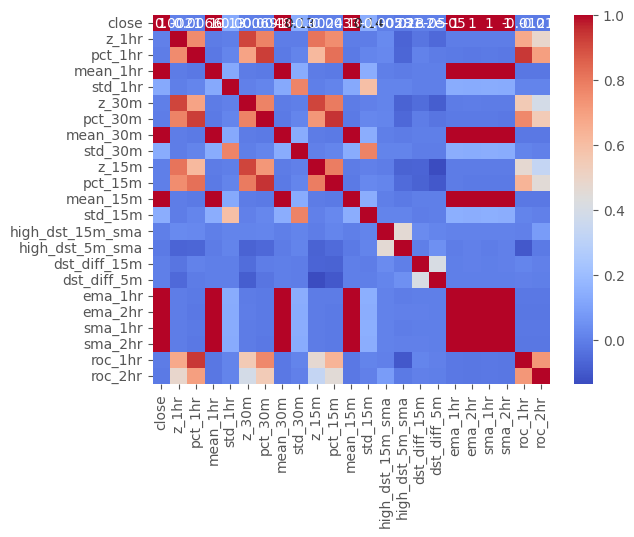

In [41]:
df_num = df_data.select_dtypes(include=['number'])
correlations = df_num.corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

The sma and ema features seem to be very correlated to the mean of past hour / 30m. Remove them

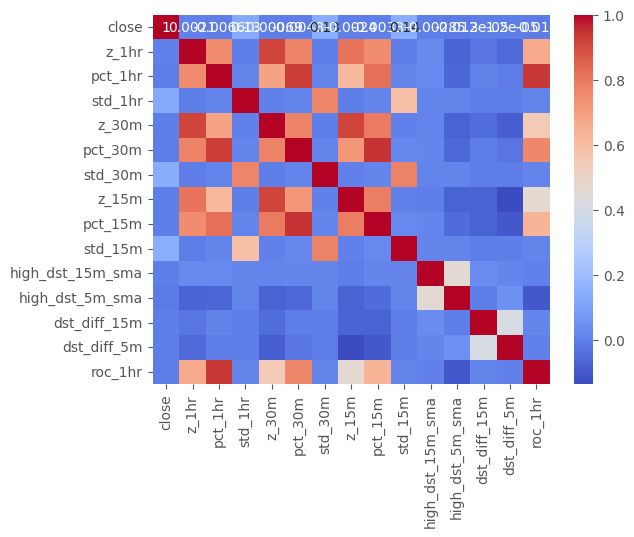

In [42]:
df_data = df_data.drop(['ema_1hr', 'ema_2hr', 'sma_1hr', 'sma_2hr', 'roc_2hr', 'mean_1hr', 'mean_30m', 'mean_15m'], axis=1)
df_num = df_data.select_dtypes(include=['number'])
correlations = df_num.corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

# Simple model building  
- Use 2010 to 2017 as training data and 2018 to 2019 as validation data
- Use the features at 1030 to predict direction at 1045

In [43]:
df_data = df_data[df_data['datetime'].dt.time >= datetime.time(hour=9, minute=0)]

df_train = df_data[df_data['datetime'].dt.year <= 2017]
df_val = df_data[df_data['datetime'].dt.year >= 2018]

In [44]:
features = [
    'close', 'z_1hr', 'pct_1hr', 'std_1hr', 'z_30m', 'pct_30m', 'std_30m', 'z_15m', 'pct_15m', 'std_15m',
    'high_dst_15m_sma', 'high_dst_5m_sma', 'dst_diff_15m', 'dst_diff_5m', 'roc_1hr'
]

# features = [
#     'pct_1hr', 'dst_diff_15m', 'std_30m', 'z_15m'
# ]

In [45]:
Xtr, ytr = [], []
for day, df_day in tqdm.tqdm(df_train.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0: continue
    x = df_day[df_day['datetime'].dt.time == datetime.time(hour=10, minute=30)][features]
    y = df_day[df_day['datetime'].dt.time == datetime.time(hour=10, minute=45)]['direction_30m'].iloc[0]
    Xtr.append(x)
    ytr.append(y)

Xvl, yvl = [], []
for day, df_day in tqdm.tqdm(df_val.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0: continue
    x = df_day[df_day['datetime'].dt.time == datetime.time(hour=10, minute=30)][features]

    # there's 1 day where data is not complete, drop it
    if x.shape[0] == 0: continue

    y = df_day[df_day['datetime'].dt.time == datetime.time(hour=10, minute=45)]['direction_30m'].iloc[0]
    Xvl.append(x)
    yvl.append(y)

Xtr = pd.concat(Xtr)
Xvl = pd.concat(Xvl)

 71%|███████   | 2059/2913 [00:00<00:00, 6907.45it/s]

100%|██████████| 715/715 [00:00<00:00, 5785.06it/s]


In [46]:
le = LabelEncoder()
le.fit(ytr)

ytr = le.transform(ytr).reshape(-1, 1)
yvl = le.transform(yvl).reshape(-1, 1)

In [47]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
xgb_model.fit(Xtr, ytr)
y_pred = xgb_model.predict(Xvl)

print('Accuracy:', accuracy_score(yvl, y_pred))
print('Classification Report:\n', classification_report(yvl, y_pred, target_names=le.classes_))

Accuracy: 0.6213592233009708
Classification Report:
               precision    recall  f1-score   support

        down       0.71      0.55      0.62        40
     neutral       0.19      0.21      0.20        14
          up       0.70      0.80      0.74        49

    accuracy                           0.62       103
   macro avg       0.53      0.52      0.52       103
weighted avg       0.63      0.62      0.62       103



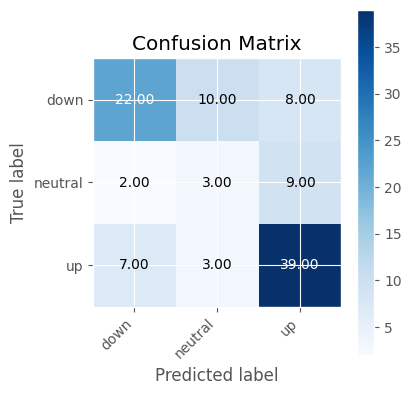

In [48]:
plot_confusion_matrix(yvl, y_pred, le.classes_)

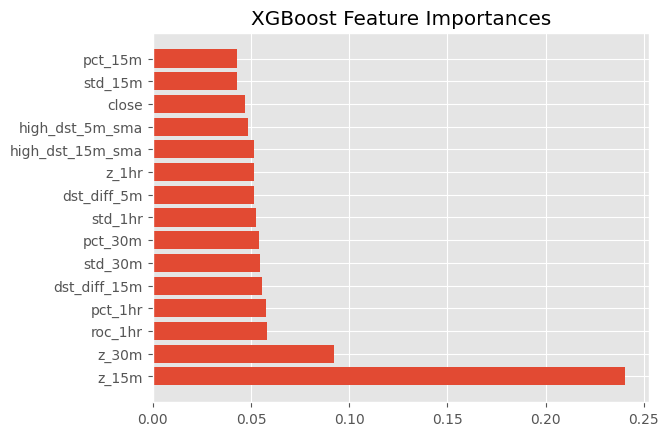

In [49]:
feature_importances = xgb_model.feature_importances_
feature_names = xgb_model.get_booster().feature_names
df_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df_importance = df_importance.sort_values(by='importance', ascending=False)

plt.barh(df_importance['feature'], df_importance['importance'])
# plt.xticks(rotation=90)
plt.title('XGBoost Feature Importances')
plt.show()

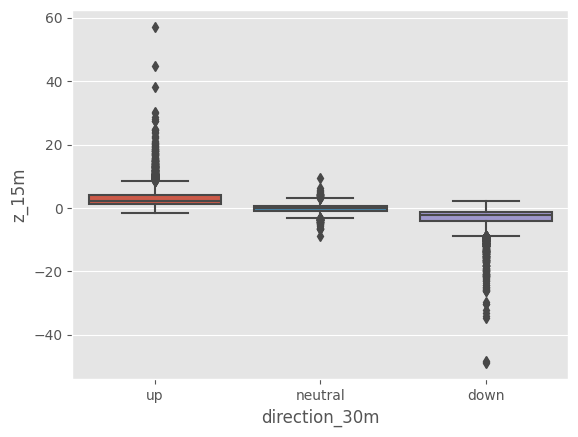

In [50]:
sns.boxplot(x='direction_30m', y='z_15m', data=df_data)
plt.show()

Accuracy: 0.6699029126213593
Classification Report:
               precision    recall  f1-score   support

        down       0.68      0.80      0.74        40
     neutral       0.14      0.07      0.10        14
          up       0.73      0.73      0.73        49

    accuracy                           0.67       103
   macro avg       0.52      0.54      0.52       103
weighted avg       0.63      0.67      0.65       103



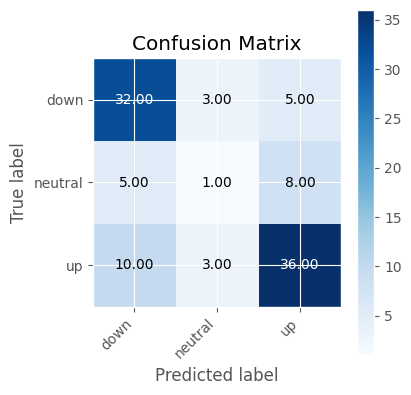

In [51]:
Xtr = Xtr.loc[:, 'z_15m']
Xvl = Xvl.loc[:, 'z_15m']

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
xgb_model.fit(Xtr, ytr)
y_pred = xgb_model.predict(Xvl)

print('Accuracy:', accuracy_score(yvl, y_pred))
print('Classification Report:\n', classification_report(yvl, y_pred, target_names=le.classes_))
plot_confusion_matrix(yvl, y_pred, le.classes_)